In [0]:
#Databricks Exercise

#1. Introduction to Databricks
#Task: Creating a Databricks Notebook

# Read the CSV file into a DataFrame
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/teacher_data-1.csv")

In [0]:
#Performing DataFrame Operations

# Show the first few rows of the DataFrame
df1.show(5)

# Display the schema of the DataFrame
df1.printSchema()



+---------+-------------+-------+-----------------+------+
|TeacherID|         Name|Subject|YearsOfExperience|Salary|
+---------+-------------+-------+-----------------+------+
|        1|     John Doe|   Math|               10| 55000|
|        2|   Jane Smith|English|                8| 52000|
|        3| Mark Johnson|Science|               12| 60000|
|        4|  Emily Davis|History|                5| 48000|
|        5|Michael Brown|   Math|               15| 62000|
+---------+-------------+-------+-----------------+------+
only showing top 5 rows

root
 |-- TeacherID: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Subject: string (nullable = true)
 |-- YearsOfExperience: string (nullable = true)
 |-- Salary: string (nullable = true)



In [0]:
# Count the number of rows in the DataFrame
row_count = df1.count()
print(f"Number of rows in the DataFrame: {row_count}")

# Filter the DataFrame for teachers with more than 10 years of experience
experienced_teachers = df1.filter(df1["YearsOfExperience"] > 10)
print("experienced teachers")
experienced_teachers.show()

# Group by subject and calculate the average salary for each subject
avg_salary = df1.groupBy('Subject').agg({'Salary': 'avg'})
print("Avg salary")
avg_salary.show()

# Sort the DataFrame by salary in descending order
df1.orderBy(df1["Salary"].desc()).show()





Number of rows in the DataFrame: 10
experienced teachers
+---------+-------------+-------+-----------------+------+
|TeacherID|         Name|Subject|YearsOfExperience|Salary|
+---------+-------------+-------+-----------------+------+
|        3| Mark Johnson|Science|               12| 60000|
|        5|Michael Brown|   Math|               15| 62000|
|        9|   James Hall|   Math|               11| 58000|
+---------+-------------+-------+-----------------+------+

Avg salary
+-------+------------------+
|Subject|       avg(Salary)|
+-------+------------------+
|Science|           55500.0|
|   Math|58333.333333333336|
|English|           52000.0|
|History|           47500.0|
+-------+------------------+

+---------+-------------+-------+-----------------+------+
|TeacherID|         Name|Subject|YearsOfExperience|Salary|
+---------+-------------+-------+-----------------+------+
|        5|Michael Brown|   Math|               15| 62000|
|        3| Mark Johnson|Science|               1

In [0]:
#2. Setting Up Azure Databricks Workspace and Configuring Clusters
#Task: Configuring Clusters
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
#3. Real-Time Data Processing with Databricks
#Task: Implementing Databricks for Real-Time Data Processing

# Read the CSV file into a DataFrame
df2 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/event_data_1.csv")

df2.show()

+-------------------+----------+-------+------------------+
|         event_time|event_type|user_id|            amount|
+-------------------+----------+-------+------------------+
|2024-09-01 18:46:00|      view|    125|               0.0|
|2024-09-01 14:20:00|      view|    590|               0.0|
|2024-09-01 21:34:00|     click|    626|214.32524639559162|
|2024-09-01 18:50:00|  purchase|    847| 82.90346160818179|
|2024-09-01 18:15:00|      view|    861|               0.0|
|2024-09-01 17:24:00|     click|    338| 760.3444131051176|
|2024-09-01 02:01:00|  purchase|    466| 708.8959146777304|
|2024-09-01 07:46:00|  purchase|    503| 842.3751935682646|
|2024-09-01 20:38:00|     click|    435|  887.214593409447|
|2024-09-01 05:30:00|  purchase|     91|  847.908033341641|
|2024-09-01 01:27:00|  purchase|    375|454.64873191440034|
|2024-09-01 23:16:00|     click|    889|380.58625997139364|
|2024-09-01 18:43:00|  purchase|     60|111.30156572734003|
|2024-09-01 14:31:00|     click|    499|

In [0]:
# Define the schema for the streaming data
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType

schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("amount", FloatType(), True)
])

# Read the CSV file as a streaming DataFrame
input_path = "/FileStore/shared_uploads/varshinie.1006@gmail.com/event_data_1.csv"

# Read the file as if it's a stream
df_stream = spark.readStream \
    .option("header", "true") \
    .schema(schema) \
    .csv(input_path)

# Display the streaming DataFrame (for debugging purposes)
df_stream.printSchema()


root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- amount: float (nullable = true)



In [0]:
from pyspark.sql.functions import window, sum

# Real-time aggregation: Sum amount by event_type and per minute
aggregated_stream = df_stream \
    .groupBy(
        window("event_time", "1 minute"),  # Group by 1-minute window
        "event_type"
    ) \
    .agg(sum("amount").alias("total_amount"))

# Output the real-time aggregation to the console
query = aggregated_stream.writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", "false") \
    .start()

# Wait for the streaming query to terminate
query.awaitTermination()


---------------------------------------------------------------------------
StreamingQueryException                   Traceback (most recent call last)
File <command-1012568290716912>:19
     12 query = aggregated_stream.writeStream \
     13     .outputMode("complete") \
     14     .format("console") \
     15     .option("truncate", "false") \
     16     .start()
     18 # Wait for the streaming query to terminate
---> 19 query.awaitTermination()

File /databricks/spark/python/pyspark/sql/streaming/query.py:198, in StreamingQuery.awaitTermination(self, timeout)
    196     return self._jsq.awaitTermination(int(timeout * 1000))
    197 else:
--> 198     return self._jsq.awaitTermination()

File /databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py:1321, in JavaMember.__call__(self, *args)
   1315 command = proto.CALL_COMMAND_NAME +\
   1316     self.command_header +\
   1317     args_command +\
   1318     proto.END_COMMAND_PART
   1320 answer = self.gateway_client

In [0]:
# Real-time aggregation: Sum amount by event_type and per minute
schema="event_time TIMESTAMP, event_type STRING, user_id STRING, amount DOUBLE"
streamind_data=spark.readStream.format("csv").schema(schema).option("header","true").load("dbfs:/FileStore/")
# Real-time aggregation
aggregated_data=(streamind_data.groupBy("event_type").agg({"amount":"sum"}).withColumnRenamed("sum(amount)","total_amount"))
query = (aggregated_data.writeStream
         .outputMode("complete")
         .format("console")
         .start())

In [0]:
query.stop()


In [0]:
#4. Data Exploration and Visualization in Databricks
#Task: Visualizing Data in Databricks
df3 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/Sales_data_1.csv")

df3.show()

+--------------+----------+------+--------+-----------+----------------+-----------+
|transaction_id|product_id| price|quantity|   category|transaction_date|customer_id|
+--------------+----------+------+--------+-----------+----------------+-----------+
|             1|       150|299.99|       2|Electronics|      2024-01-15|       1005|
|             2|       120| 19.99|       5|    Grocery|      2024-02-10|       1012|
|             3|       135| 49.50|       3|   Clothing|      2024-03-18|       1003|
|             4|       180|899.99|       1|  Furniture|      2024-04-21|       1023|
|             5|       160| 15.00|       7|       Toys|      2024-05-05|       1007|
|             6|       145| 79.99|       4|Electronics|      2024-06-02|       1015|
|             7|       170|129.99|       2|   Clothing|      2024-07-15|       1027|
|             8|       190|350.00|       1|  Furniture|      2024-08-09|       1030|
|             9|       110|  5.99|      10|    Grocery|      2024

In [0]:
# Display schema of the DataFrame
df3.printSchema()

# Describe to see summary statistics of numerical columns
df3.describe().show()

# Count the total number of rows
row_count = df3.count()
print(f"Total rows in the dataset: {row_count}")


root
 |-- transaction_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- category: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- customer_id: string (nullable = true)

+-------+------------------+------------------+------------------+------------------+--------+----------------+---------------+
|summary|    transaction_id|        product_id|             price|          quantity|category|transaction_date|    customer_id|
+-------+------------------+------------------+------------------+------------------+--------+----------------+---------------+
|  count|                10|                10|                10|                10|      10|              10|             10|
|   mean|               5.5|             153.5|           189.594|               4.0|    null|            null|         1014.0|
| stddev|3.0276503540974917|26.357583770562545|277.1870472

In [0]:
from pyspark.sql.functions import col, sum

# Calculate total sales by category
sales_by_category = df3.withColumn("total_sales", col("price") * col("quantity")) \
    .groupBy("category") \
    .agg(sum("total_sales").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

# Display the result as a table
display(sales_by_category)

df3.select("price", "quantity").display()


category,total_sales
Furniture,1249.99
Electronics,919.94
Clothing,408.48
Toys,332.5
Grocery,159.85


price,quantity
299.99,2
19.99,5
49.50,3
899.99,1
15.00,7
79.99,4
129.99,2
350.00,1
5.99,10
45.50,5


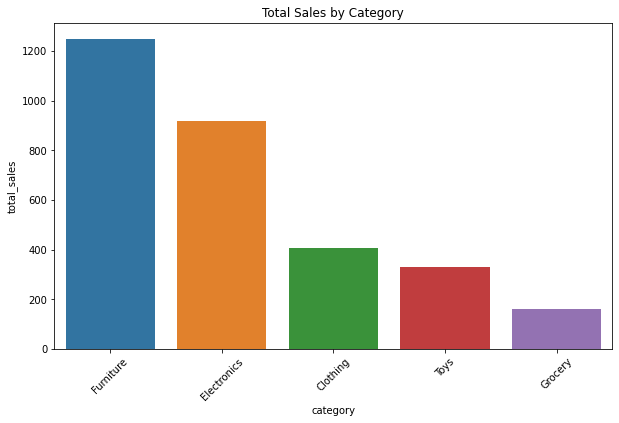

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas for visualization
sales_by_category_pd = sales_by_category.toPandas()

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x='category', y='total_sales', data=sales_by_category_pd)
plt.title("Total Sales by Category")
plt.xticks(rotation=45)
plt.show()


In [0]:
#6. Reading and Writing Data in Databricks
#Task: Reading and Writing Data in Various Formats

# Reading CSV file
df4 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/sales_data.csv")

df4.show()


+----------+------+--------+--------+-----+
|      Date|Region| Product|Quantity|Price|
+----------+------+--------+--------+-----+
|2024-09-01| North|Widget A|      10|25.50|
|2024-09-01| South|Widget B|       5|15.75|
|2024-09-02| North|Widget A|      12|25.50|
|2024-09-02|  East|Widget C|       8|22.50|
|2024-09-03|  West|Widget A|      15|25.50|
|2024-09-03| South|Widget B|      20|15.75|
|2024-09-03|  East|Widget C|      10|22.50|
|2024-09-04| North|Widget D|       7|30.00|
|2024-09-04|  West|Widget B|       9|15.75|
+----------+------+--------+--------+-----+



In [0]:
# Writing to JSON
df4.write.json("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/sales_data_json")
print("Written to json file format")

Written to json file format


In [0]:
# Writing to Parquet
df4.write.parquet("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/sales_data_parquet")
print("Written to parquet file format")

Written to parquet file format


In [0]:
# Writing to Delta format
df4.write.format("delta").save("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/sales_data_delta")
print("Written to delta table format")

Written to delta table format


In [0]:
#7. Analyzing and Visualizing Streaming Data with Databricks
#Task: Analyzing Streaming Data

df5 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/event_data_1.csv")

# Path to the saved CSV file
streaming_path = "/FileStore/shared_uploads/varshinie.1006@gmail.com/event_data_1.csv"

# Reading the dataset in streaming mode
streaming_df = (spark.readStream.format("csv").option("header", "true").schema(schema).load(streaming_path))

# Show streaming schema
streaming_df.printSchema()


root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- amount: double (nullable = true)



In [0]:
from pyspark.sql.functions import window

# Aggregating data by event type and time window
aggregated_streaming_df = streaming_df \
    .groupBy(window("event_time", "1 minute"), "event_type") \
    .agg({"amount": "sum"}) \
    .withColumnRenamed("sum(amount)", "total_amount")

# Write the results to the console to verify
query = aggregated_streaming_df.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()




In [0]:
query.stop()


In [0]:
#8. Introduction to Databricks Delta Lake
#Task: Using Delta Lake for Data Versioning

df6 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/event_data_1.csv")

#Write DataFrame to Delta format 
df6.write.format("delta").save("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/event_data_delta")
print("Data written to Delta format")


Data written to Delta format


In [0]:
delta_table_path = "/FileStore/shared_uploads/varshinie.1006@gmail.com/event_data_delta"
# Perform updates by loading the Delta table
delta_table = spark.read.format("delta").load(delta_table_path)

# Simulating an update: Changing 'amount' for 'purchase' event types
from pyspark.sql.functions import expr
updated_data = delta_table.withColumn("amount", expr("case when event_type = 'purchase' then amount * 1.10 else amount end"))

# Overwrite the Delta table with the updated data
updated_data.write.format("delta").mode("overwrite").save(delta_table_path)

updated_data.show()


+-------------------+----------+-------+------------------+
|         event_time|event_type|user_id|            amount|
+-------------------+----------+-------+------------------+
|2024-09-01 18:46:00|      view|    125|               0.0|
|2024-09-01 14:20:00|      view|    590|               0.0|
|2024-09-01 21:34:00|     click|    626|214.32524639559162|
|2024-09-01 18:50:00|  purchase|    847|100.31318854589998|
|2024-09-01 18:15:00|      view|    861|               0.0|
|2024-09-01 17:24:00|     click|    338| 760.3444131051176|
|2024-09-01 02:01:00|  purchase|    466| 857.7640567600539|
|2024-09-01 07:46:00|  purchase|    503|1019.2739842176004|
|2024-09-01 20:38:00|     click|    435|  887.214593409447|
|2024-09-01 05:30:00|  purchase|     91|1025.9687203433857|
|2024-09-01 01:27:00|  purchase|    375| 550.1249656164244|
|2024-09-01 23:16:00|     click|    889|380.58625997139364|
|2024-09-01 18:43:00|  purchase|     60|134.67489453008145|
|2024-09-01 14:31:00|     click|    499|

In [0]:
# Reading the Delta table as of version 0 (before the update)
df_version_0 = spark.read.format("delta").option("versionAsOf", 0).load(delta_table_path)
df_version_0.show(5)

# Reading the Delta table as of version 1 (after the update)
df_version_1 = spark.read.format("delta").option("versionAsOf", 1).load(delta_table_path)
df_version_1.show(5)


+-------------------+----------+-------+------------------+
|         event_time|event_type|user_id|            amount|
+-------------------+----------+-------+------------------+
|2024-09-01 18:46:00|      view|    125|               0.0|
|2024-09-01 14:20:00|      view|    590|               0.0|
|2024-09-01 21:34:00|     click|    626|214.32524639559162|
|2024-09-01 18:50:00|  purchase|    847| 82.90346160818179|
|2024-09-01 18:15:00|      view|    861|               0.0|
+-------------------+----------+-------+------------------+
only showing top 5 rows

+-------------------+----------+-------+------------------+
|         event_time|event_type|user_id|            amount|
+-------------------+----------+-------+------------------+
|2024-09-01 18:46:00|      view|    125|               0.0|
|2024-09-01 14:20:00|      view|    590|               0.0|
|2024-09-01 21:34:00|     click|    626|214.32524639559162|
|2024-09-01 18:50:00|  purchase|    847| 91.19380776899997|
|2024-09-01 18:

In [0]:
# Optimize the Delta table
spark.sql(f"OPTIMIZE delta.`{delta_table_path}`")


Out[51]: DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:b

In [0]:
# Vacuum the Delta table to delete old data versions
spark.sql(f"VACUUM delta.`{delta_table_path}` RETAIN 0 HOURS")


---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-1012568290716932>:2
      1 # Vacuum the Delta table to delete old data versions
----> 2 spark.sql(f"VACUUM delta.`{delta_table_path}` RETAIN 0 HOURS")

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/session.py:1387, in SparkSession.sql(self, sqlQuery, args, **kwargs)
   1385 try:
   1386     litArgs = {k: _to_java_column(lit(v)) for k, v in (args or {}).items()}
-> 1387     return DataFrame(self._jsparkSession.sql(sqlQuery, litArgs), self)
   1388 finally:
   1

In [0]:
# Query the optimized Delta table
optimized_df = spark.read.format("delta").load(delta_table_path)
optimized_df.show(5)


+-------------------+----------+-------+------------------+
|         event_time|event_type|user_id|            amount|
+-------------------+----------+-------+------------------+
|2024-09-01 18:46:00|      view|    125|               0.0|
|2024-09-01 14:20:00|      view|    590|               0.0|
|2024-09-01 21:34:00|     click|    626|214.32524639559162|
|2024-09-01 18:50:00|  purchase|    847| 91.19380776899997|
|2024-09-01 18:15:00|      view|    861|               0.0|
+-------------------+----------+-------+------------------+
only showing top 5 rows



In [0]:
#9. Managed and Unmanaged Tables
#Task: Creating Managed and Unmanaged Tables
# Save the sales data as a managed Delta table
df4.write.format("delta").mode("overwrite").saveAsTable("managed_sales_table")


In [0]:
# Define the external location to save the data for unmanaged table
external_path = "/FileStore/tables/unmanaged_sales_data"

# Save the sales data to the external location
df4.write.format("delta").mode("overwrite").save(external_path)

# Create an unmanaged Delta table pointing to this external location
spark.sql(f"""
    CREATE TABLE unmanaged_sales_table
    USING DELTA
    LOCATION '{external_path}'
""")


Out[56]: DataFrame[]

In [0]:
# Select the first 5 records from the managed table
spark.sql("SELECT * FROM managed_sales_table LIMIT 5").show()

# Select the first 5 records from the unmanaged table
spark.sql("SELECT * FROM unmanaged_sales_table LIMIT 5").show()


+----------+------+--------+--------+-----+
|      Date|Region| Product|Quantity|Price|
+----------+------+--------+--------+-----+
|2024-09-01| North|Widget A|      10|25.50|
|2024-09-01| South|Widget B|       5|15.75|
|2024-09-02| North|Widget A|      12|25.50|
|2024-09-02|  East|Widget C|       8|22.50|
|2024-09-03|  West|Widget A|      15|25.50|
+----------+------+--------+--------+-----+

+----------+------+--------+--------+-----+
|      Date|Region| Product|Quantity|Price|
+----------+------+--------+--------+-----+
|2024-09-01| North|Widget A|      10|25.50|
|2024-09-01| South|Widget B|       5|15.75|
|2024-09-02| North|Widget A|      12|25.50|
|2024-09-02|  East|Widget C|       8|22.50|
|2024-09-03|  West|Widget A|      15|25.50|
+----------+------+--------+--------+-----+



In [0]:
#10. Views and Temporary Views
#Task: Working with Views in Databricks

# Create a view from the sales data
df4.createOrReplaceTempView("sales_view")

# Query the view
spark.sql("SELECT * FROM sales_view LIMIT 5").show()


+----------+------+--------+--------+-----+
|      Date|Region| Product|Quantity|Price|
+----------+------+--------+--------+-----+
|2024-09-01| North|Widget A|      10|25.50|
|2024-09-01| South|Widget B|       5|15.75|
|2024-09-02| North|Widget A|      12|25.50|
|2024-09-02|  East|Widget C|       8|22.50|
|2024-09-03|  West|Widget A|      15|25.50|
+----------+------+--------+--------+-----+



In [0]:
# Create a temporary view
df4.createOrReplaceTempView("temp_sales_view")

# Query the temporary view
spark.sql("SELECT product, SUM(price) AS total_sales FROM temp_sales_view GROUP BY product").show()


+--------+-----------+
| product|total_sales|
+--------+-----------+
|Widget C|       45.0|
|Widget B|      47.25|
|Widget A|       76.5|
|Widget D|       30.0|
+--------+-----------+



In [0]:
# Create a global temporary view
df4.createOrReplaceGlobalTempView("global_sales_view")

# Query the global temporary view
spark.sql("SELECT * FROM global_temp.global_sales_view LIMIT 5").show()


+----------+------+--------+--------+-----+
|      Date|Region| Product|Quantity|Price|
+----------+------+--------+--------+-----+
|2024-09-01| North|Widget A|      10|25.50|
|2024-09-01| South|Widget B|       5|15.75|
|2024-09-02| North|Widget A|      12|25.50|
|2024-09-02|  East|Widget C|       8|22.50|
|2024-09-03|  West|Widget A|      15|25.50|
+----------+------+--------+--------+-----+



In [0]:
#Assignment: Delta Lake Concepts
#Task 1: Creating Delta Table using Three Methods

#1. Load the given CSV and JSON datasets into Databricks.

df_employees = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/employees.csv")

df_products = spark.read.format("json").load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/products.json")

In [0]:
# Load the Employees CSV file into a DataFrame and cache it
df_employees = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/employees.csv").cache()

# Load the Products JSON file into a DataFrame and cache it
df_products = spark.read.format("json") \
    .option("inferSchema", "true") \
    .load("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/products.json").cache()


In [0]:
#2. Create a Delta table using the following three methods:
#Create a Delta table from a DataFrame.

df_employees.write.format("delta").mode("overwrite").save("/delta/employees")


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-1573338673244432>:6
      1 #2. Create a Delta table using the following three methods:
      2 #Create a Delta table from a DataFrame.
      3 
      4 #df_employees.write.format("delta").mode("overwrite").save("/delta/employees")
----> 6 df_products.write.format("delta").mode("overwrite").save("/delta/products")

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/readwriter.py:1397, in DataFrameWriter.save(self, path, format, mode, partitionBy, **options)
   1395 

In [0]:
# Create temporary view for Employees DataFrame
df_employees.createOrReplaceTempView("df_employees")

# Create temporary view for Products DataFrame
df_products.createOrReplaceTempView("df_products")


In [0]:
%sql
--Use SQL to create a Delta table.
-- Employees 
CREATE TABLE employees_delta
USING delta
AS SELECT * FROM df_employees;

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-1573338673244434>:7
      5     display(df)
      6     return df
----> 7   _sqldf = ____databricks_percent_sql()
      8 finally:
      9   del ____databricks_percent_sql

File <command-1573338673244434>:4, in ____databricks_percent_sql()
      2 def ____databricks_percent_sql():
      3   import base64
----> 4   df = spark.sql(base64.standard_b64decode("LS1Vc2UgU1FMIHRvIGNyZWF0ZSBhIERlbHRhIHRhYmxlLgotLSBFbXBsb3llZXMgCkNSRUFURSBUQUJMRSBkZWx0YV9lbXBsb3llZXMKVVNJTkcgZGVsdGEKQVMgU0VMRUNUICogRlJPTSBkZl9lbXBsb3llZXM=").decode())
      5   display(df)
      6   return df

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         modu

In [0]:
#Convert both the CSV and JSON files into Delta format.

df_employees.write.format("delta").mode("overwrite").save("/delta/employees_converted")

df_products.write.format("delta").mode("overwrite").save("/delta/products_converted")

In [0]:
#Task 2: Merge and Upsert (Slowly Changing Dimension - SCD)
#1. Load the Delta table for employees created in Task 1.
employees_delta_df = spark.read.format("delta").load("/delta/employees")


In [0]:
#2. Merge the new employee data into the employees Delta table.
new_employee_data = [
    (102, "Alice", "Finance", "2023-02-15", 75000),  # Updated Salary
    (106, "Olivia", "HR", "2023-06-10", 65000)       # New Employee
]

columns = ["EmployeeID", "EmployeeName", "Department", "JoiningDate", "Salary"]

new_employees_df = spark.createDataFrame(new_employee_data, columns)


In [0]:
#3. If an employee exists, update their salary. If the employee is new, insert their details.

#new_employees_df.createOrReplaceTempView("new_employees_view")

spark.sql("""
MERGE INTO delta.`/delta/employees` AS target
USING new_employees_view AS source
ON target.EmployeeID = source.EmployeeID
WHEN MATCHED THEN
  UPDATE SET target.Salary = source.Salary
WHEN NOT MATCHED THEN
  INSERT (EmployeeID, EmployeeName, Department, JoiningDate, Salary)
  VALUES (source.EmployeeID, source.EmployeeName, source.Department, source.JoiningDate, source.Salary);

""")

Out[27]: DataFrame[num_affected_rows: bigint, num_updated_rows: bigint, num_deleted_rows: bigint, num_inserted_rows: bigint]

In [0]:
# Verify the updated Delta table
updated_employees_df = spark.read.format("delta").load("/delta/employees")
updated_employees_df.show()


+----------+------------+-----------+-----------+------+
|EmployeeID|EmployeeName| Department|JoiningDate|Salary|
+----------+------------+-----------+-----------+------+
|       101|        John|         HR| 2023-01-10| 50000|
|       103|        Mark|Engineering| 2023-03-20| 85000|
|       104|        Emma|      Sales| 2023-04-01| 55000|
|       105|        Liam|  Marketing| 2023-05-12| 60000|
|       102|       Alice|    Finance| 2023-02-15| 75000|
|       106|      Olivia|         HR| 2023-06-10| 65000|
+----------+------------+-----------+-----------+------+



In [0]:
#Task 3: Internals of Delta Table
#1. Explore the internals of the employees Delta table using Delta Lake features.
# Describe the Delta table to see its metadata and internals
spark.sql("DESCRIBE DETAIL delta.`/delta/employees`").show(truncate=False)

# Show the schema of the Delta table
spark.sql("DESCRIBE delta.`/delta/employees`").show()

# Check the number of files in the Delta table
spark.sql("DESCRIBE HISTORY delta.`/delta/employees`").show()


+------+------------------------------------+----+-----------+---------------------+-----------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+----------+
|format|id                                  |name|description|location             |createdAt              |lastModified       |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |statistics|
+------+------------------------------------+----+-----------+---------------------+-----------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+----------+
|delta |06f06877-5161-4c56-9546-5e301a90923f|null|null       |dbfs:/delta/employees|2024-09-17 04:11:26.246|2024-09-17 05:02:16|[]              |3       |5059       |{}        |1               |2               |[appendOnly, invariants]|{}        |
+------+

In [0]:
#2. Check the transaction history of the table.
spark.sql("DESCRIBE HISTORY delta.`/delta/employees`").show(truncate=False)


+-------+-------------------+----------------+------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+------------------+--------------------+-----------+-----------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-------------

In [0]:
%sql
--3. Perform Time Travel and retrieve the table before the previous merge operation.
-- Retrieve the Delta table using a version number
SELECT * FROM delta.`/delta/employees` VERSION AS OF 1;

-- Retrieve the Delta table using a valid timestamp
SELECT * FROM delta.`/delta/employees` TIMESTAMP AS OF '2024-09-17T04:30:00.000Z';


EmployeeID,EmployeeName,Department,JoiningDate,Salary
101,John,HR,2023-01-10,50000
102,Alice,Finance,2023-02-15,70000
103,Mark,Engineering,2023-03-20,85000
104,Emma,Sales,2023-04-01,55000
105,Liam,Marketing,2023-05-12,60000


In [0]:
#Task 4: Optimize Delta Table
#1. Optimize the employees Delta table for better performance.
spark.sql("""
OPTIMIZE delta.`/delta/employees`;
""")


Out[37]: DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:b

In [0]:
#2. Use Z-ordering on the Department column for improved query performance.
spark.sql("""
OPTIMIZE delta.`/delta/employees` ZORDER BY (Department);
""")


Out[38]: DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:b

In [0]:
#Task 5: Time Travel with Delta Table
#1. Retrieve the employees Delta table as it was before the last merge.
spark.sql("""
DESCRIBE HISTORY delta.`/delta/employees`;
""")

Out[39]: DataFrame[version: bigint, timestamp: timestamp, userId: string, userName: string, operation: string, operationParameters: map<string,string>, job: struct<jobId:string,jobName:string,jobRunId:string,runId:string,jobOwnerId:string,triggerType:string>, notebook: struct<notebookId:string>, clusterId: string, readVersion: bigint, isolationLevel: string, isBlindAppend: boolean, operationMetrics: map<string,string>, userMetadata: string, engineInfo: string]

In [0]:
#2. Query the table at a specific version to view the older records.
spark.sql("""
SELECT * FROM delta.`/delta/employees` VERSION AS OF 2;
""")

Out[41]: DataFrame[EmployeeID: string, EmployeeName: string, Department: string, JoiningDate: string, Salary: string]

In [0]:
#Task 6: Vacuum Delta Table
#1. Use the vacuum operation on the employees Delta table to remove old versions and free up disk space.
spark.sql("""
VACUUM delta.`/delta/employees`;
""")


Out[42]: DataFrame[path: string]

In [0]:
#2. Set the retention period to 7 days and ensure that old files are deleted.
spark.sql("""
VACUUM delta.`/delta/employees` RETAIN 168 HOURS;
""")

Out[43]: DataFrame[path: string]

In [0]:
#Assignment: Structured Streaming and Transformations on Streams
#Task 1: Ingest Streaming Data from CSV Files
streaming_folder_path = "/mnt/streaming_csv_data"

dbutils.fs.mkdirs(streaming_folder_path)


Out[44]: True

In [0]:
#2. Set up a structured streaming source to continuously read CSV data from this folder.
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType

schema = StructType([
    StructField("TransactionID", StringType(), True),
    StructField("TransactionDate", DateType(), True),
    StructField("ProductID", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("Price", IntegerType(), True)
])

streaming_df = spark.readStream \
    .schema(schema) \
    .csv(streaming_folder_path) 


In [0]:
#3. Ensure that the streaming query reads the data continuously in append mode and
displays the results in the console.
query = streaming_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", False) \
    .start()

#query.awaitTermination()


In [0]:
#Task 2: Stream Transformations
#Add a new column for the TotalAmount ( Quantity * Price ).
#Filter records where the Quantity is greater than 1.
from pyspark.sql.functions import col

transformed_df = streaming_df \
    .withColumn("TotalAmount", col("Quantity") * col("Price")) \
    .filter(col("Quantity") > 1)


In [0]:
#2. Write the transformed stream to a memory sink to see the updated results continuously.
query = transformed_df.writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("transformed_stream") \
    .start()

#query.awaitTermination()


In [0]:
# Display the results from the memory table
display(spark.table("transformed_stream"))


TransactionID,TransactionDate,ProductID,Quantity,Price,TotalAmount


In [0]:
#Task 3: Aggregations on Streaming Data
#1. Implement an aggregation on the streaming data:
#Group the data by ProductID and calculate the total sales for each product
from pyspark.sql.functions import col, sum as sum_

# Aggregate data: sum of TotalAmount grouped by ProductID
aggregated_df = transformed_df \
    .groupBy("ProductID") \
    .agg(
        sum_("TotalAmount").alias("TotalSales")
    )

In [0]:
# 2. Ensure the stream runs in update mode, so only updated results are output to the sink.

query = aggregated_df.writeStream \
    .outputMode("update") \
    .format("memory") \
    .queryName("aggregated_sales_stream") \
    .start()

#query.awaitTermination()

display(spark.table("aggregated_sales_stream"))



ProductID,TotalSales


In [0]:
#Task 4: Writing Streaming Data to File Sinks
#1. After transforming and aggregating the data, write the streaming results to a Parquet sink.
#2. Ensure that you configure a checkpoint location to store progress and ensure recovery in case of failure.
parquet_sink_path = "/mnt/streaming_parquet_data"
checkpoint_location = "/mnt/checkpoints/aggregated_sales"

query = aggregated_df.writeStream \
    .outputMode("update") \
    .format("parquet") \
    .option("path", parquet_sink_path) \
    .option("checkpointLocation", checkpoint_location) \
    .start()

query.awaitTermination()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<command-1573338673244458>", line 28, in <module>
    query = aggregated_df.writeStream \
  File "/databricks/spark/python/pyspark/sql/streaming/readwriter.py", line 1385, in start
    return self._sq(self._jwrite.start())
  File "/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1321, in __call__
    return_value = get_return_value(
  File "/databricks/spark/python/pyspark/errors/exceptions.py", line 234, in deco
    raise converted from None
pyspark.errors.exceptions.AnalysisException: Append output mode not supported when there are streaming aggregations on streaming DataFrames/DataSets without watermark;
~Aggregate [ProductID#9531], [ProductID#9531, sum(TotalAmount#9549) AS TotalSales#9676L]
+- ~EventTimeWatermark TransactionDate#9662: timestamp, 

In [0]:
#Task 5: Handling Late Data using Watermarks
#1. Introduce a watermark on the TransactionDate column to handle late data arriving in the stream.
#2. Set the watermark to 1 day to allow late data within a 24-hour period and discard data that is older.
from pyspark.sql.functions import col, to_timestamp, sum as sum_

transformed_df_with_timestamp = transformed_df \
    .withColumn("TransactionDate", to_timestamp(col("TransactionDate")))

watermarked_df = transformed_df_with_timestamp \
    .withWatermark("TransactionDate", "1 day")

aggregated_df = watermarked_df \
    .groupBy("ProductID") \
    .agg(
        sum_("TotalAmount").alias("TotalSales")
    )

parquet_sink_path = "/mnt/streaming_parquet_data"

checkpoint_location = "/mnt/checkpoints/aggregated_sales"

query = aggregated_df.writeStream \
    .outputMode("append") \
    .format("parquet") \
    .option("path", parquet_sink_path) \
    .option("checkpointLocation", checkpoint_location) \
    .start()

query.awaitTermination()

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-1573338673244460>:28
     25 checkpoint_location = "/mnt/checkpoints/aggregated_sales"
     27 # Write the aggregated data to a Parquet sink with checkpointing
---> 28 query = aggregated_df.writeStream \
     29     .outputMode("append") \
     30     .format("parquet") \
     31     .option("path", parquet_sink_path) \
     32     .option("checkpointLocation", checkpoint_location) \
     33     .start()
     35 # Await termination to keep the streaming query running
     36 query.awaitTermination()

File /databricks/spark/python/pyspark/sql/streaming/readwriter.py:1385, in DataStreamWriter.start(self, path, format, outputMode, partitionBy, queryName, **options)
   1383     self.queryName(queryName)
   1384 if path is None:
-> 1385     return self._sq(self._jwrite.start())
   1386 else:
   1387     return self._sq(self._jw

In [0]:
#Task 6: Streaming from Multiple Sources
#1. Simulate a scenario where two streams of data are being ingested:
#Stream 1: Incoming transaction data (same as Task 1).
#Stream 2: Product information (CSV with columns: ProductID, ProductName, Category).
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

transaction_schema = StructType([
    StructField("TransactionID", StringType(), True),
    StructField("TransactionDate", TimestampType(), True),
    StructField("ProductID", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("Price", IntegerType(), True)
])

product_schema = StructType([
    StructField("ProductID", StringType(), True),
    StructField("ProductName", StringType(), True),
    StructField("Category", StringType(), True)
])

transaction_stream_df = spark.readStream \
    .schema(transaction_schema) \
    .csv("/mnt/streaming_csv_data")  # Update with the path to your CSV folder

product_stream_df = spark.readStream \
    .schema(product_schema) \
    .csv("/mnt/streaming_csv_data")  # Update with the path to your CSV folder


In [0]:
#2. Perform a join on the two streams using the ProductID column and display the combined stream results.
from pyspark.sql.functions import col

joined_stream_df = transaction_stream_df \
    .join(product_stream_df, on="ProductID", how="inner")

display_df = joined_stream_df \
    .select(
        col("TransactionID"),
        col("TransactionDate"),
        col("ProductID"),
        col("ProductName"),
        col("Category"),
        col("Quantity"),
        col("Price"),
        (col("Quantity") * col("Price")).alias("TotalAmount")
    )

query = display_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

#query.awaitTermination()


In [0]:
#Task 7: Stopping and Restarting Streaming Queries
#1. Stop the streaming query and explore the results.
query.stop()

print("Streaming Query Stopped.")


Streaming Query Stopped. Exploring Results...


In [0]:
#2. Restart the query and ensure that it continues from the last processed data by utilizing the checkpoint.

checkpoint_location = "/mnt/checkpoints/aggregated_sales"

query = aggregated_df.writeStream \
    .outputMode("append") \
    .format("parquet") \
    .option("path", parquet_sink_path) \
    .option("checkpointLocation", checkpoint_location) \
    .start()

query.awaitTermination()


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-1573338673244464>:5
      1 #2. Restart the query and ensure that it continues from the last processed data by utilizing the checkpoint.
      3 checkpoint_location = "/mnt/checkpoints/aggregated_sales"
----> 5 query = aggregated_df.writeStream \
      6     .outputMode("append") \
      7     .format("parquet") \
      8     .option("path", parquet_sink_path) \
      9     .option("checkpointLocation", checkpoint_location) \
     10     .start()

File /databricks/spark/python/pyspark/sql/streaming/readwriter.py:1385, in DataStreamWriter.start(self, path, format, outputMode, partitionBy, queryName, **options)
   1383     self.queryName(queryName)
   1384 if path is None:
-> 1385     return self._sq(self._jwrite.start())
   1386 else:
   1387     return self._sq(self._jwrite.start(path))

File /databricks/spark/python/lib/p

In [0]:
#Assignment: Creating a Complete ETL Pipeline using Delta Live Tables (DLT)

#Task 1: Create an ETL Pipeline using DLT (Python)
#1. Create a Delta Live Table pipeline using PySpark to perform the following:
#Read the source data from a CSV or Parquet file.
#Transform the data by performing the following:
#Add a new column for TotalAmount which is the result of
#multiplying Quantity by Price .
#Filter records where the Quantity is greater than 1.
#Load the transformed data into a Delta table.
#2. Ensure the pipeline is repeatable and can handle incremental loads by re-running with new data.

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("ETL Pipeline with DLT") \
    .getOrCreate()

source_df = spark.read.csv("dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/orders.csv", header=True, inferSchema=True)

transformed_df = source_df \
    .withColumn("TotalAmount", col("Quantity") * col("Price")) \
    .filter(col("Quantity") > 1)

transformed_df.write.format("delta").mode("append").saveAsTable("delta_table_orders")

existing_df = spark.read.format("delta").table("delta_table_orders")

incremental_df = transformed_df.join(
    existing_df.select("OrderID"),
    on="OrderID",
    how="left_anti"  
)

incremental_df.write.format("delta").mode("append").saveAsTable("delta_table_orders")

# Stop Spark Session
spark.stop()



In [0]:
#Task 2: Create an ETL Pipeline using DLT (SQL)
#1. Create a similar Delta Live Table pipeline using SQL:
#Use SQL to read the source data, perform the same transformations (as above), and write the data into a Delta table.
spark.sql("""
CREATE TABLE IF NOT EXISTS source_orders (
    OrderID INT,
    OrderDate DATE,
    CustomerID STRING,
    Product STRING,
    Quantity INT,
    Price DECIMAL(10, 2)
)
USING DELTA;
""")

Out[3]: DataFrame[]

In [0]:
%sql

-- Load data from CSV into a temporary view
CREATE OR REPLACE TEMPORARY VIEW temp_source_orders
USING csv
OPTIONS (
    path 'dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/orders.csv',
    header 'true',
    inferSchema 'true'
);

-- Insert data from the temporary view into the Delta table
INSERT INTO source_orders
SELECT * FROM temp_source_orders;



num_affected_rows,num_inserted_rows
5,5


In [0]:
%sql
-- Create or replace the target Delta table for transformed data
CREATE OR REPLACE TABLE transformed_orders AS
SELECT
    OrderID,
    OrderDate,
    CustomerID,
    Product,
    Quantity,
    Price,
    Quantity * Price AS TotalAmount
FROM source_orders
WHERE Quantity > 1;


num_affected_rows,num_inserted_rows


In [0]:
%sql
--Ensure the pipeline can process incremental data without losing records or creating duplicates.
-- Upsert new records into the transformed Delta table
MERGE INTO transformed_orders AS target
USING (
    SELECT
        OrderID,
        OrderDate,
        CustomerID,
        Product,
        Quantity,
        Price,
        Quantity * Price AS TotalAmount
    FROM source_orders
    WHERE Quantity > 1
) AS source
ON target.OrderID = source.OrderID
WHEN MATCHED THEN
    UPDATE SET
        target.OrderDate = source.OrderDate,
        target.CustomerID = source.CustomerID,
        target.Product = source.Product,
        target.Quantity = source.Quantity,
        target.Price = source.Price,
        target.TotalAmount = source.TotalAmount
WHEN NOT MATCHED THEN
    INSERT (OrderID, OrderDate, CustomerID, Product, Quantity, Price, TotalAmount)
    VALUES (source.OrderID, source.OrderDate, source.CustomerID, source.Product, source.Quantity, source.Price, source.TotalAmount);


num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
3,3,0,0


In [0]:
%sql
--Task 3: Perform Read, Write, Update, and Delete Operations on Delta Table (SQL + PySpark)
--1. Read the data from the Delta table created in Task 1 and Task 2.
SELECT * FROM transformed_orders;


OrderID,OrderDate,CustomerID,Product,Quantity,Price,TotalAmount
101,2024-01-01,C001,Laptop,2,1000.00,2000.00
103,2024-01-03,C003,Tablet,3,300.00,900.00
105,2024-01-05,C005,Mouse,5,20.00,100.00


In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Delta Table Operations") \
    .getOrCreate()

# Read data from the Delta table using PySpark
df = spark.read.format("delta").table("transformed_orders")
df.show()


+-------+----------+----------+-------+--------+-------+-----------+
|OrderID| OrderDate|CustomerID|Product|Quantity|  Price|TotalAmount|
+-------+----------+----------+-------+--------+-------+-----------+
|    101|2024-01-01|      C001| Laptop|       2|1000.00|    2000.00|
|    103|2024-01-03|      C003| Tablet|       3| 300.00|     900.00|
|    105|2024-01-05|      C005|  Mouse|       5|  20.00|     100.00|
+-------+----------+----------+-------+--------+-------+-----------+



In [0]:
%sql
--2. Update the table by changing the price of a product (e.g., increase the price of laptops by 10%).

UPDATE transformed_orders
SET Price = Price * 1.10
WHERE Product = 'Laptop';




num_affected_rows
1


In [0]:
#3. Delete rows from the Delta table where the quantity is less than 2.
spark.sql("""          
DELETE FROM transformed_orders
WHERE Quantity < 2;
 """)
#4. Insert a new record into the Delta table using PySpark or SQL.
spark.sql("""
INSERT INTO transformed_orders
VALUES (106, '2024-01-06', 'C006', 'Keyboard', 3, 50, 150);
""")

Out[15]: DataFrame[num_affected_rows: bigint, num_inserted_rows: bigint]

In [0]:
#Task 4: Merge Data (Slowly Changing Dimension - SCD Type 2)
#1. Create a new dataset representing updated orders with new prices and products.
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW updated_orders AS
SELECT * FROM (
    VALUES
    (101, '2024-01-10', 'C001', 'Laptop', 2, 1200),
    (106, '2024-01-12', 'C006', 'Keyboard', 3, 50)
) AS updated_orders(OrderID, OrderDate, CustomerID, Product, Quantity, Price);

          """)


Out[16]: DataFrame[]

In [0]:
#Implement a MERGE operation to simulate a Slowly Changing Dimension Type 2 (SCD2) scenario. Ensure that:
#The Quantity , Price , and TotalAmount columns are updated if there is a match on OrderID .
#If no match is found, insert the new record into the Delta table.
spark.sql("""
MERGE INTO transformed_orders AS target
USING updated_orders AS source
ON target.OrderID = source.OrderID
WHEN MATCHED THEN
    UPDATE SET 
        target.Quantity = source.Quantity,
        target.Price = source.Price,
        target.TotalAmount = source.Quantity * source.Price,
        target.OrderDate = source.OrderDate,
        target.CustomerID = source.CustomerID,
        target.Product = source.Product
WHEN NOT MATCHED THEN
    INSERT (OrderID, OrderDate, CustomerID, Product, Quantity, Price, TotalAmount)
    VALUES (source.OrderID, source.OrderDate, source.CustomerID, source.Product, source.Quantity, source.Price, source.Quantity * source.Price);
""")

Out[17]: DataFrame[num_affected_rows: bigint, num_updated_rows: bigint, num_deleted_rows: bigint, num_inserted_rows: bigint]

In [0]:
#Task 5: Explore Delta Table Internals
#1. Inspect the Delta table's transaction logs and explore the metadata using SQL queries:
#Display the history of changes to the Delta table using the DESCRIBE HISTORY command.
spark.sql("""
         DESCRIBE HISTORY transformed_orders; 
          """)
#Check the file size and modification times using DESCRIBE DETAIL .
spark.sql("""
          DESCRIBE DETAIL transformed_orders;
          """)

Out[18]: DataFrame[format: string, id: string, name: string, description: string, location: string, createdAt: timestamp, lastModified: timestamp, partitionColumns: array<string>, numFiles: bigint, sizeInBytes: bigint, properties: map<string,string>, minReaderVersion: int, minWriterVersion: int, tableFeatures: array<string>, statistics: map<string,bigint>]

In [0]:
#Task 6: Time Travel in Delta Tables
#1. Use time travel to query the Delta table as it existed at a previous point in time.
#Query the table as it existed before the last merge operation.
spark.sql("""
DESCRIBE HISTORY transformed_orders;
""")
#Demonstrate time travel by using both the version of the table and the timestamp.
spark.sql("""
          SELECT * FROM transformed_orders VERSION AS OF 5;
          """)

spark.sql("""
         SELECT * FROM transformed_orders TIMESTAMP AS OF '2024-09-17T08:56:56';
          """)

Out[23]: DataFrame[OrderID: int, OrderDate: date, CustomerID: string, Product: string, Quantity: int, Price: decimal(10,2), TotalAmount: decimal(21,2)]

In [0]:
#Task 7: Optimize Delta Table
#1. Optimize the Delta table for faster queries using Z-Ordering.
#Optimize the table on the Product column to reduce I/O and improve query performance.
spark.sql("""
         OPTIMIZE transformed_orders
ZORDER BY (Product); 
          """)
#2. Use vacuum to remove any old files that are no longer necessary after the optimization process.
spark.sql("""
          VACUUM transformed_orders;
      """)


Out[24]: DataFrame[path: string]

In [0]:
#Task 8: Converting Parquet Files to Delta Format
#1. You are provided with Parquet files containing historical order data. Convert these files into a Delta table format using either PySpark or SQL.


# Save DataFrame as Parquet
source_df.write.format("parquet").mode("overwrite").save("/mnt/delta/historical_orders_parquet")

source_df.write.format("delta").mode("overwrite").saveAsTable("historical_orders_delta")

#Perform a simple query on the converted Delta table to verify the conversion.
spark.sql("SELECT * FROM historical_orders_delta").show()



+-------+----------+----------+-------+--------+-----+
|OrderID| OrderDate|CustomerID|Product|Quantity|Price|
+-------+----------+----------+-------+--------+-----+
|    101|2024-01-01|      C001| Laptop|       2| 1000|
|    102|2024-01-02|      C002|  Phone|       1|  500|
|    103|2024-01-03|      C003| Tablet|       3|  300|
|    104|2024-01-04|      C004|Monitor|       1|  150|
|    105|2024-01-05|      C005|  Mouse|       5|   20|
+-------+----------+----------+-------+--------+-----+



In [0]:
#Assignment: Creating and Scheduling a Job on Databricks using Notebooks
#Task 1: Prepare Your Notebook
#1. Create a new Notebook in your Databricks workspace.
#Use PySpark for data processing.
#In the notebook, read a CSV file (use the provided sample data), perform a transformation, and write the transformed data into a Delta table.
#The transformation should include:
#Adding a new column ( TotalAmount ) which is the product of Quantity and Price .
#Filtering rows where Quantity is greater than 5.

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
spark = SparkSession.builder.appName("TransformData").getOrCreate()

csv_file_path = "dbfs:/FileStore/shared_uploads/varshinie.1006@gmail.com/orders.csv" 

df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csv_file_path)

df_transformed = df.withColumn("TotalAmount", col("Quantity") * col("Price"))

df_filtered = df_transformed.filter(col("Quantity") > 5)
df_filtered.show()

delta_table_path = "/mnt/delta/transformed_orders_delta"  

df_filtered.write.format("delta").mode("overwrite").save(delta_table_path)

spark.sql("""
CREATE TABLE IF NOT EXISTS transformed_orders_delta
USING DELTA
LOCATION '{}'
""".format(delta_table_path))

spark.sql("SELECT * FROM transformed_orders_delta").show()


+-------+---------+----------+-------+--------+-----+-----------+
|OrderID|OrderDate|CustomerID|Product|Quantity|Price|TotalAmount|
+-------+---------+----------+-------+--------+-----+-----------+
+-------+---------+----------+-------+--------+-----+-----------+

+-------+---------+----------+-------+--------+-----+-----------+
|OrderID|OrderDate|CustomerID|Product|Quantity|Price|TotalAmount|
+-------+---------+----------+-------+--------+-----+-----------+
+-------+---------+----------+-------+--------+-----+-----------+

